In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, classification_report
import re
import string
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer # This is for Feature Extraction
import os

# from google.colab import drive

def get_news_label(n):
    """
    Maps numerical prediction to 'Fake News' or 'True News'.
    Corresponds to the final output blocks in the diagram.
    """
    if n == 0:
        return "Fake News"
    elif n == 1:
        return "True News"

def preprocess_text(text):
    """
    Applies text preprocessing steps.
    Corresponds to the 'preprocessing' step in the diagram.
    """
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def process_user_query_and_predict(user_query, trained_model, feature_extractor):
    """
    Handles a user query, preprocesses it, extracts features, and makes a prediction
    using the trained model.
    Corresponds to 'User query' feeding into 'Trained model' to produce 'True news' or 'Fake news'.
    """
    print("\n--- Processing User Query and Predicting News Type ---")
    query_df = pd.DataFrame({"text": [user_query]})

    # Preprocessing the user query
    query_df["text"] = query_df["text"].apply(preprocess_text)

    # Feature extraction for the user query
    query_features = feature_extractor.transform(query_df["text"])

    # Prediction using the trained model
    prediction_result = trained_model.predict(query_features)

    prediction_label = get_news_label(prediction_result[0])
    print(f"\nModel ({type(trained_model).__name__}) Prediction for User Query: {prediction_label}")
    return prediction_label

def train_and_evaluate_classifier(model, training_dataset_features, training_dataset_labels,
                                  testing_dataset_features, testing_dataset_labels, output_filepath):
    """
    Fits a given classifier model, makes predictions, and prints evaluation metrics
    to a specified file.
    Corresponds to 'Training the classifier' and 'Model evaluation' in the diagram.
    """
    with open(output_filepath, 'a') as f:
        print(f"\n--- Model Evaluation for {type(model).__name__} ---", file=f)

        # Training the classifier
        model.fit(training_dataset_features, training_dataset_labels)
        print("Classifier trained successfully.", file=f)

        predictions = model.predict(testing_dataset_features)
        print("Predictions made on Testing dataset.", file=f)

        acc_score = accuracy_score(testing_dataset_labels, predictions)
        print(f"Accuracy Score: {acc_score:.4f}", file=f)

        report_str = classification_report(testing_dataset_labels, predictions, digits=4)
        print("\nClassification Report:", file=f)
        print(report_str, file=f)
        print("-" * 60, file=f)

    print(f"\nEvaluation results for {type(model).__name__} saved to: {output_filepath}")
    return model, predictions

def plot_model_evaluation_curve(model, model_name, features, labels, output_dir, random_state, scoring='accuracy'):
    """
    Generates and plots a learning curve for a given model, saving the plot.
    This is part of 'Model evaluation' and can inform 'Model tuning'.
    """
    print(f"Generating learning curve for {model_name} (Model evaluation)...")
    train_sizes, train_scores, test_scores = learning_curve(
        model, features, labels, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5),
        scoring=scoring, random_state=random_state
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel(f"Score ({scoring})")
    plt.title(f"Learning Curve ({model_name}) - Model Evaluation")
    plt.legend(loc="best")
    plt.grid()

    plot_filename = os.path.join(output_dir, f"learning_curve_{model_name.replace(' ', '_').lower()}.png")
    plt.savefig(plot_filename)
    plt.close()
    print(f"Learning curve for {model_name} saved to: {plot_filename}")


def run_fake_news_detection_pipeline(data_base_path, output_base_path, test_data_split_ratio, random_seed):
    """
    Orchestrates the entire fake news detection pipeline as per the diagram.
    """
    # Ensure output directories exist
    os.makedirs(output_base_path, exist_ok=True)
    results_output_dir = os.path.join(output_base_path, 'results')
    os.makedirs(results_output_dir, exist_ok=True)

    # Start: Loading the 'dataset'
    df_fake_news = pd.read_csv(os.path.join(data_base_path, "Fake.csv"))
    df_true_news = pd.read_csv(os.path.join(data_base_path, "True.csv"))

    print("Loading and preparing initial dataset...")
    print(f"True news head:\n{df_true_news.head(2)}\n")
    print(f"Fake news head:\n{df_fake_news.head(2)}\n")

    df_fake_news["class"] = 0
    df_true_news["class"] = 1

    print(f"Initial dataset shapes: Fake={df_fake_news.shape}, True={df_true_news.shape}")

    # Separate a small portion for manual testing (outside the main train/test split)
    df_fake_manual_test_set = df_fake_news.tail(10).copy()
    df_fake_news.drop(df_fake_news.tail(10).index, axis = 0, inplace = True)

    df_true_manual_test_set = df_true_news.tail(10).copy()
    df_true_news.drop(df_true_news.tail(10).index, axis = 0, inplace = True)

    print(f"Dataset shapes after separating manual test data: Fake={df_fake_news.shape}, True={df_true_news.shape}")

    df_fake_manual_test_set["class"] = 0
    df_true_manual_test_set["class"] = 1

    df_manual_testing_set = pd.concat([df_fake_manual_test_set,df_true_manual_test_set], axis = 0)
    manual_testing_filepath = os.path.join(results_output_dir, "manual_testing_data.csv")
    df_manual_testing_set.to_csv(manual_testing_filepath, index=False)
    print(f"Manual testing data saved to: {manual_testing_filepath}")

    # Merge fake and true news to form the complete dataset
    full_dataset_df = pd.concat([df_fake_news, df_true_news], axis =0 )
    print(f"\nMerged dataset head:\n{full_dataset_df.head(2)}\n")

    # Preprocessing Step 1: Dropping irrelevant columns
    # This is part of the 'preprocessing' block in the diagram
    full_dataset_df = full_dataset_df.drop(["title", "subject","date"], axis = 1)
    print("Columns after dropping (Preprocessing): ", full_dataset_df.columns.tolist())

    print(f"Missing values (Preprocessing):\n{full_dataset_df.isnull().sum()}\n")

    # Shuffle the dataset
    full_dataset_df = full_dataset_df.sample(frac = 1, random_state=random_seed).reset_index(drop=True)
    print(f"Dataset after shuffling (Preprocessing):\n{full_dataset_df.head(2)}\n")

    # Preprocessing Step 2: Applying text cleaning (wordopt)
    # This is also part of the 'preprocessing' block
    print("Applying text preprocessing to text column (Preprocessing)...")
    full_dataset_df["text"] = full_dataset_df["text"].apply(preprocess_text)
    print(f"Example of processed text: {full_dataset_df['text'].iloc[0][:100]}...\n")

    # Prepare features (X) and labels (y)
    text_data_for_features = full_dataset_df["text"]
    labels = full_dataset_df["class"]

    # Splitting into Training dataset and Testing dataset
    # This directly creates 'Testing dataset' and 'Training dataset'
    raw_training_data, raw_testing_data, training_labels, testing_labels = train_test_split(
        text_data_for_features, labels, test_size=test_data_split_ratio, random_state=random_seed
    )

    print(f"Data split into Training dataset ({len(raw_training_data)} samples) "
          f"and Testing dataset ({len(raw_testing_data)} samples).")

    # Feature extraction using TfidfVectorizer
    # This is the 'Feature extraction' step
    print("Vectorizing text data using TfidfVectorizer (Feature extraction)...")
    feature_extractor = TfidfVectorizer()
    training_dataset_features = feature_extractor.fit_transform(raw_training_data)
    testing_dataset_features = feature_extractor.transform(raw_testing_data)
    print(f"Vectorized Training dataset (features) shape: {training_dataset_features.shape}")
    print(f"Vectorized Testing dataset (features) shape: {testing_dataset_features.shape}")

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    evaluation_results_file = os.path.join(results_output_dir, f"model_evaluation_report_{timestamp}.txt")

    with open(evaluation_results_file, 'w') as f:
        f.write("--- Model Evaluation Report ---\n")
        f.write(f"Timestamp: {pd.Timestamp.now()}\n")
        f.write(f"Test Size Ratio: {test_data_split_ratio}\n")
        f.write(f"Random State: {random_seed}\n")
        f.write("-" * 60 + "\n")

        models_to_evaluate = {
            "Random Forest Classifier": RandomForestClassifier(random_state=random_seed),
            "Logistic Regression": LogisticRegression(random_state=random_seed, solver='liblinear'),
            "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=random_seed),
            "Decision Tree Classifier": DecisionTreeClassifier(random_state=random_seed)
        }

    for model_name, model_instance in models_to_evaluate.items():
        print(f"\nProcessing {model_name}...")
        # This calls 'Training the classifier' and 'Model evaluation'
        fitted_model, _ = train_and_evaluate_classifier(
            model_instance, training_dataset_features, training_labels,
            testing_dataset_features, testing_labels, evaluation_results_file
        )

        # This is part of 'Model evaluation' and informs 'Model tuning'
        #plot_model_evaluation_curve(model_instance, model_name,
        #                              training_dataset_features, training_labels,
        #                              results_output_dir, random_seed)

        # Simulating 'User query' and prediction from 'Trained model' to 'True news'/'Fake news'
        user_input_news = input(f"Enter news text to test with {model_name} (User query): ")
        process_user_query_and_predict(user_input_news, fitted_model, feature_extractor)


In [ ]:
data_input_path = '/content/drive/MyDrive/FakeNews/data'
output_destination_path = '/content/drive/MyDrive/FakeNews/output'
run_fake_news_detection_pipeline(data_input_path, output_destination_path, test_data_split_ratio=0.2, random_seed=42)


Loading and preparing initial dataset...
True news head:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   

Fake news head:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  

Initial dataset shapes: Fake=(23481, 5), T

--- Datasets Loaded and Combined Successfully ---

First 5 records of the combined dataset:
                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date label  
0    February 13, 2017  FAKE  
1       April 5, 2017   TRUE  
2  September 27, 2017   TRUE  
3         May 22, 2017  FA

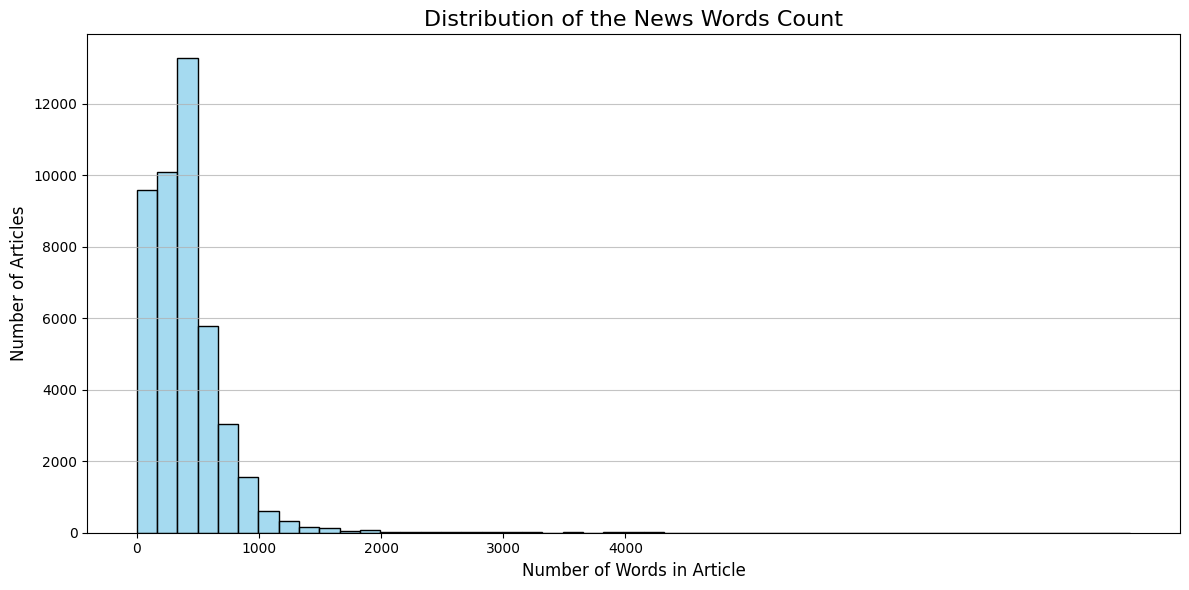


--- Distribution of 'label' column (Combined Dataset) ---
label
FAKE    23481
TRUE    21417
Name: count, dtype: int64

Percentage distribution of 'label' column:
label
FAKE    52.298543
TRUE    47.701457
Name: proportion, dtype: float64

--- Sample of 'title' column (Combined Dataset) ---
0    Ben Stein Calls Out 9th Circuit Court: Committ...
1    Trump drops Steve Bannon from National Securit...
2    Puerto Rico expects U.S. to lift Jones Act shi...
3     OOPS: Trump Just Accidentally Confirmed He Le...
4    Donald Trump heads for Scotland to reopen a go...
Name: title, dtype: object


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os # Import os for path joining
import numpy as np # Import numpy for linspace and array operations

# --- Configuration for Google Colab ---
# IMPORTANT: Update this path to where your 'Fake.csv' and 'True.csv' files are in Google Drive.
# Example: If your files are in 'My Drive/my_project/data/', set it to '/content/drive/My Drive/my_project/data'
data_base_path =  '/content/drive/MyDrive/FakeNews/data'

try:
    # Construct full paths to the datasets using the base path
    fake_news_filepath = os.path.join(data_base_path, "Fake.csv")
    true_news_filepath = os.path.join(data_base_path, "True.csv")

    # Load the datasets
    df_fake = pd.read_csv(fake_news_filepath)
    df_true = pd.read_csv(true_news_filepath)

    # Add a 'label' column to differentiate between fake and true news
    df_fake['label'] = 'FAKE'
    df_true['label'] = 'TRUE'

    # Combine the two dataframes into a single dataframe
    df = pd.concat([df_fake, df_true], ignore_index=True)

    # Shuffle the combined dataframe to mix fake and true news entries
    # frac=1 shuffles all rows, reset_index(drop=True) resets the index after shuffling.
    df = df.sample(frac=1, random_state=42).reset_index(drop=True) # Added random_state for reproducibility

    print("--- Datasets Loaded and Combined Successfully ---")
    print("\nFirst 5 records of the combined dataset:")
    print(df.head())

    print("\n--- Combined Dataset Information ---")
    df.info()

    print("\n--- Combined Dataset Shape (Rows, Columns) ---")
    print(df.shape)

    print("\n--- Descriptive Statistics for Numerical Columns (Combined Dataset) ---")
    print(df.describe())

    print("\n--- Missing Values per Column (Combined Dataset) ---")
    print(df.isnull().sum())

    # Perform word count analysis if a 'text' column exists
    if 'text' in df.columns:
        print("\n--- Word Count Analysis for 'text' column (Combined Dataset) ---")
        def count_words(text):
            if pd.isna(text):
                return 0
            return len(str(text).split())

        df['word_count'] = df['text'].apply(count_words)

        print(f"Total number of articles: {len(df)}")
        print(f"Average word count per article: {df['word_count'].mean():.2f}")
        print(f"Minimum word count: {df['word_count'].min()}")
        print(f"Maximum word count: {df['word_count'].max()}")
        print(f"Median word count: {df['word_count'].median()}")

        print("\nWord count quantiles (25th, 50th, 75th percentile):")
        print(df['word_count'].quantile([0.25, 0.5, 0.75]))

        print("\n--- Generating Distribution of News Words Count Figure ---")
        plt.figure(figsize=(12, 6))

        # Calculate appropriate bins based on data range
        max_words = int(df['word_count'].max())
        # Use 50 bins or adjust as needed for visual clarity
        bins = np.linspace(0, max_words, 50)

        sns.histplot(df['word_count'], bins=bins, kde=False, color='skyblue', edgecolor='black')

        plt.title('Distribution of the News Words Count', fontsize=16)
        plt.xlabel('Number of Words in Article', fontsize=12)
        plt.ylabel('Number of Articles', fontsize=12)
        plt.grid(axis='y', alpha=0.75)

        # --- MODIFIED SECTION: Control x-axis ticks ---
        # Define the tick locations you want to keep
        # For example, keep 0, 1000, 2000, 3000, 4000
        # You can adjust this list based on what you want to show
        desired_xticks = [0, 1000, 2000, 3000, 4000]
        plt.xticks(desired_xticks, fontsize=10) # Set specific x-tick locations
        # --- END MODIFIED SECTION ---

        plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.ylim(bottom=0) # Ensure the y-axis starts at 0
        plt.show()

    else:
        print("\n'text' column not found for word count analysis. Please check column names.")

    # Analyze the distribution of the 'label' column
    if 'label' in df.columns:
        print("\n--- Distribution of 'label' column (Combined Dataset) ---")
        print(df['label'].value_counts())
        print("\nPercentage distribution of 'label' column:")
        print(df['label'].value_counts(normalize=True) * 100)
    else:
        print("\n'label' column not found for categorical analysis. This indicates an issue with label assignment.")

    # Display a sample of the 'title' column if it exists
    if 'title' in df.columns:
        print("\n--- Sample of 'title' column (Combined Dataset) ---")
        print(df['title'].head())

except FileNotFoundError as fnf_e:
    print(f"\nFile not found error: {fnf_e}")
    print(f"Please ensure 'Fake.csv' and 'True.csv' are present at: {data_base_path}")
    print("Check your Google Drive mount and the `data_base_path` variable.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")
    print("Please check the dataset structure, column names, or your environment setup.")